In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# Graph creation
After collecting and pre-processing the data, the graphs are created to build a network between the stocks, using their sectors and correlation.

## Grouping by sector
The first step is to create a graph of the stocks linking every stock that belong to the same activity sector.

# 目前仅采用申万二级行业分类作为股票关系，最初级

In [4]:
stocks = pd.read_csv('data/Ashare100/raw/stocks.csv').set_index('Symbol')
stocks.head(n=10)

,Name,Sector
Symbol,,
2,万科A,房地产开发
63,中兴通讯,通信设备
301,东方盛虹,炼化及贸易
333,美的集团,白色家电
338,潍柴动力,汽车零部件
538,云南白药,中药Ⅱ
568,泸州老窖,白酒Ⅱ
651,格力电器,白色家电
725,京东方A,光学光电子


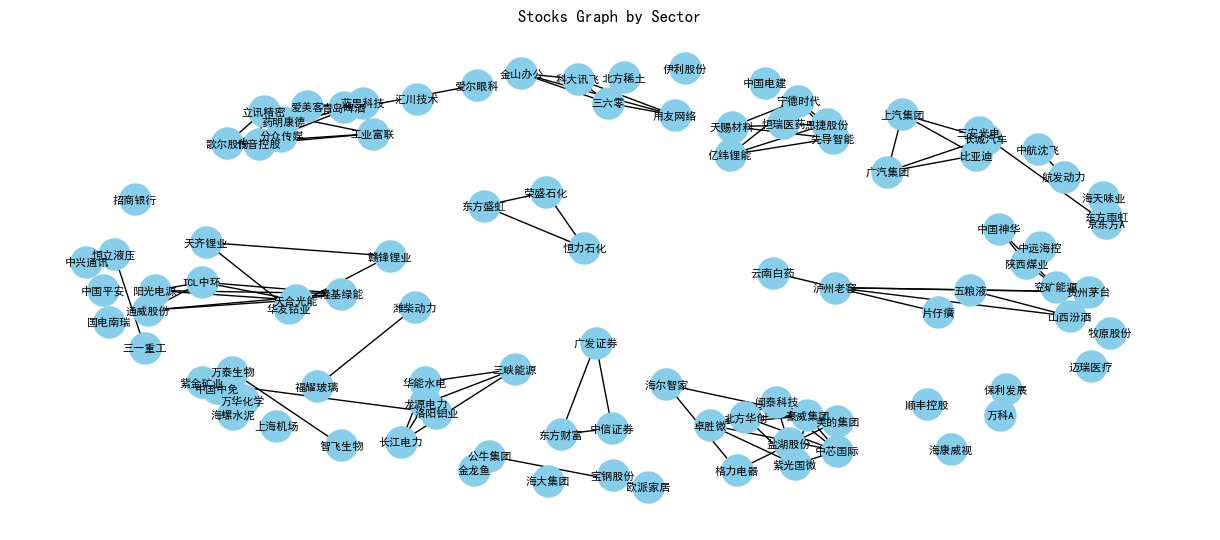

In [5]:
adj_stocks = np.array([
	[stocks.loc[stock1, 'Sector'] == stocks.loc[stock2, 'Sector'] * (stock1 != stock2) for stock1 in stocks.index] for stock2 in stocks.index
]).astype(int)
N_stock = len(stocks)
adj_stocks = np.zeros((N_stock, N_stock), dtype=int)
for idx1, stock1 in enumerate(stocks.index):
	for idx2, stock2 in enumerate(stocks.index):
		if stocks.loc[stock1, 'Sector'] == stocks.loc[stock2, 'Sector'] and stock1 != stock2:
			adj_stocks[idx1, idx2] = 1

stocks_graph = nx.from_numpy_array(adj_stocks)
stocks_graph = nx.relabel_nodes(stocks_graph, dict(enumerate(stocks['Name'])))

plt.figure(figsize=(12, 5))
nx.draw(stocks_graph, with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold', font_color='black', pos=nx.spring_layout(stocks_graph, k=.5))
plt.title('Stocks Graph by Sector')
plt.show()

In [6]:
G_relabeled = nx.convert_node_labels_to_integers(stocks_graph, first_label=0)
mapping = dict(zip(stocks_graph.nodes, range(stocks_graph.number_of_nodes())))
print(mapping)
print(G_relabeled.edges())

{'万科A': 0, '中兴通讯': 1, '东方盛虹': 2, '美的集团': 3, '潍柴动力': 4, '云南白药': 5, '泸州老窖': 6, '格力电器': 7, '京东方A': 8, '广发证券': 9, '盐湖股份': 10, '五粮液': 11, '龙源电力': 12, '分众传媒': 13, '紫光国微': 14, 'TCL中环': 15, '科大讯飞': 16, '歌尔股份': 17, '东方雨虹': 18, '海大集团': 19, '顺丰控股': 20, '北方华创': 21, '海康威视': 22, '赣锋锂业': 23, '天齐锂业': 24, '立讯精密': 25, '荣盛石化': 26, '比亚迪': 27, '天赐材料': 28, '牧原股份': 29, '恩捷股份': 30, '亿纬锂能': 31, '爱尔眼科': 32, '东方财富': 33, '智飞生物': 34, '汇川技术': 35, '阳光电源': 36, '蓝思科技': 37, '先导智能': 38, '宁德时代': 39, '迈瑞医疗': 40, '卓胜微': 41, '爱美客': 42, '金龙鱼': 43, '上海机场': 44, '宝钢股份': 45, '华能水电': 46, '中信证券': 47, '三一重工': 48, '招商银行': 49, '保利发展': 50, '上汽集团': 51, '北方稀土': 52, '兖矿能源': 53, '恒瑞医药': 54, '万华化学': 55, '恒力石化': 56, '国电南瑞': 57, '片仔癀': 58, '通威股份': 59, '贵州茅台': 60, '海螺水泥': 61, '用友网络': 62, '青岛啤酒': 63, '福耀玻璃': 64, '海尔智家': 65, '三安光电': 66, '闻泰科技': 67, '中航沈飞': 68, '山西汾酒': 69, '伊利股份': 70, '航发动力': 71, '长江电力': 72, '三峡能源': 73, '隆基绿能': 74, '中国神华': 75, '恒立液压': 76, '工业富联': 77, '陕西煤业': 78, '广汽集团': 79, '中国平安': 80, '三六零': 81, '长城汽车': 82, '中国电建': 83, '中国中免': 

In [7]:
np.save('data/Ashare100/raw/adj_stocks.npy', adj_stocks)

## Graph by fundamentals correlation
A great way to link the stocks would be using their fundamental data, such as market capitalization, p/e ratio, etc. An autoencoder is built to reduce the dimensionality of the fundamental data, and the stocks are clustered and linked following these clusters. Furthermore, the correlation between the fundamental data is used to link the stocks that have a high correlation.

In [14]:
fundamentals = pd.read_csv('../data/SP100/raw/fundamentals.csv').set_index("Symbol")
fundamentals.head(n=10)

,marketCap,trailingPE,forwardPE,pegRatio,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,,
AAPL,4.713259,-0.084433,0.860486,0.245153,0.496340,-0.198496,-0.294148,-0.100836,-0.469904,0.740955,-0.958954,-0.493373,3.233542,0.509603,0.738609
ABBV,-0.071343,0.497106,-0.597637,0.187740,0.438498,-0.404537,-0.072273,-0.100843,1.189561,-0.964698,1.212553,-0.372227,-0.368556,0.282231,-0.400966
ABT,-0.261743,0.034866,0.250051,0.344030,-0.211500,-0.413902,-0.390616,-0.100396,0.036754,-0.563069,-0.444183,-0.771202,-0.376268,-0.004358,-0.181473
ACN,-0.243207,-0.115046,0.598150,0.522648,-0.160953,0.109898,-0.024039,-0.099872,-0.177613,0.596064,-0.598022,-0.226951,-0.554558,-0.329474,-0.410431
ADBE,-0.197438,0.440583,0.649675,0.088862,-0.011240,0.073105,0.309004,-0.100099,-0.621586,0.784169,-1.319886,0.574104,-0.485990,1.153003,0.572853
AIG,-0.504422,-0.589745,-0.978102,-0.198202,-0.284676,-0.181102,-0.263370,-0.099331,-0.402952,0.138511,0.188927,0.811350,-0.459976,-0.652313,-0.477882
AMD,-0.140390,5.737339,1.074495,0.012312,-0.217844,-0.582482,-0.369485,-0.100084,-0.621586,1.747571,-1.390889,1.007462,3.173427,1.138958,-0.857169
AMGN,-0.287656,0.402503,-0.346274,0.321703,0.399112,-0.159696,0.309923,-0.100722,0.632410,-0.949447,0.366434,0.274159,-0.544986,0.505807,-0.272326
AMT,-0.440594,0.324013,1.163260,-0.300269,0.144600,-0.332958,-0.320792,-0.100739,0.502367,-0.679999,-0.059583,-0.847463,-0.561590,1.412261,0.150711


In [15]:
def get_clusters(data: np.ndarray, n_clusters: int) -> np.ndarray:
    kmeans = KMeans(n_clusters=n_clusters)
    return kmeans.fit(data).labels_

In [16]:
fundamentals_corr = fundamentals.transpose().corr(method="spearman")
fundamentals_corr = (fundamentals_corr - (fundamentals_corr == 1))  # Remove self-correlation
fundamentals_corr.head(n=10)

Symbol,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,0.000000,-0.407143,0.228571,0.057143,0.250000,-0.610714,0.467857,-0.596429,-0.014286,0.589286,...,0.057143,-0.189286,0.071429,-0.371429,-0.410714,0.592857,-0.310714,-0.078571,0.242857,-0.075000
ABBV,-0.407143,0.000000,0.292857,-0.439286,-0.514286,-0.085714,-0.235714,0.842857,0.428571,-0.321429,...,0.046429,0.182143,-0.492857,0.382143,0.057143,-0.271429,0.660714,-0.242857,0.096429,0.139286
ABT,0.228571,0.292857,0.000000,0.235714,0.042857,-0.650000,0.139286,0.357143,0.735714,0.003571,...,0.571429,0.182143,0.103571,0.039286,-0.385714,0.417857,0.185714,-0.564286,0.460714,-0.325000
ACN,0.057143,-0.439286,0.235714,0.000000,0.400000,0.060714,0.246429,-0.207143,-0.042857,0.175000,...,0.103571,0.342857,0.364286,0.275000,-0.389286,0.160714,-0.335714,-0.339286,0.146429,-0.142857
ADBE,0.250000,-0.514286,0.042857,0.400000,0.000000,-0.221429,0.482143,-0.153571,0.117857,0.164286,...,0.367857,-0.357143,0.757143,-0.496429,-0.167857,0.610714,-0.789286,-0.139286,-0.278571,-0.660714
AIG,-0.610714,-0.085714,-0.650000,0.060714,-0.221429,0.000000,-0.289286,-0.064286,-0.635714,-0.257143,...,-0.300000,-0.075000,0.021429,0.446429,0.685714,-0.600000,0.235714,0.660714,-0.264286,0.546429
AMD,0.467857,-0.235714,0.139286,0.246429,0.482143,-0.289286,0.000000,-0.221429,-0.117857,0.746429,...,-0.125000,-0.132143,-0.035714,-0.335714,-0.357143,0.182143,-0.335714,-0.171429,0.357143,-0.232143
AMGN,-0.596429,0.842857,0.357143,-0.207143,-0.153571,-0.064286,-0.221429,0.000000,0.567857,-0.485714,...,0.221429,0.160714,-0.107143,0.246429,0.046429,-0.121429,0.414286,-0.382143,-0.107143,-0.221429
AMT,-0.014286,0.428571,0.735714,-0.042857,0.117857,-0.635714,-0.117857,0.567857,0.000000,-0.360714,...,0.710714,-0.082143,0.178571,0.021429,-0.271429,0.350000,-0.003571,-0.646429,-0.003571,-0.575000


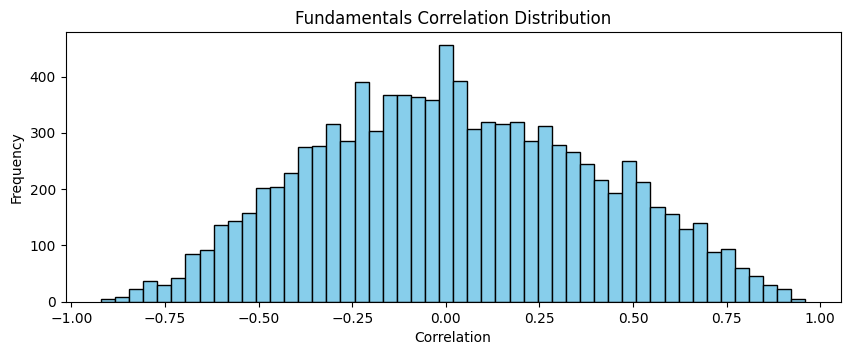

In [17]:
plt.figure(figsize=(10, 3.5))
plt.hist(fundamentals_corr.values.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.title('Fundamentals Correlation Distribution')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.show()

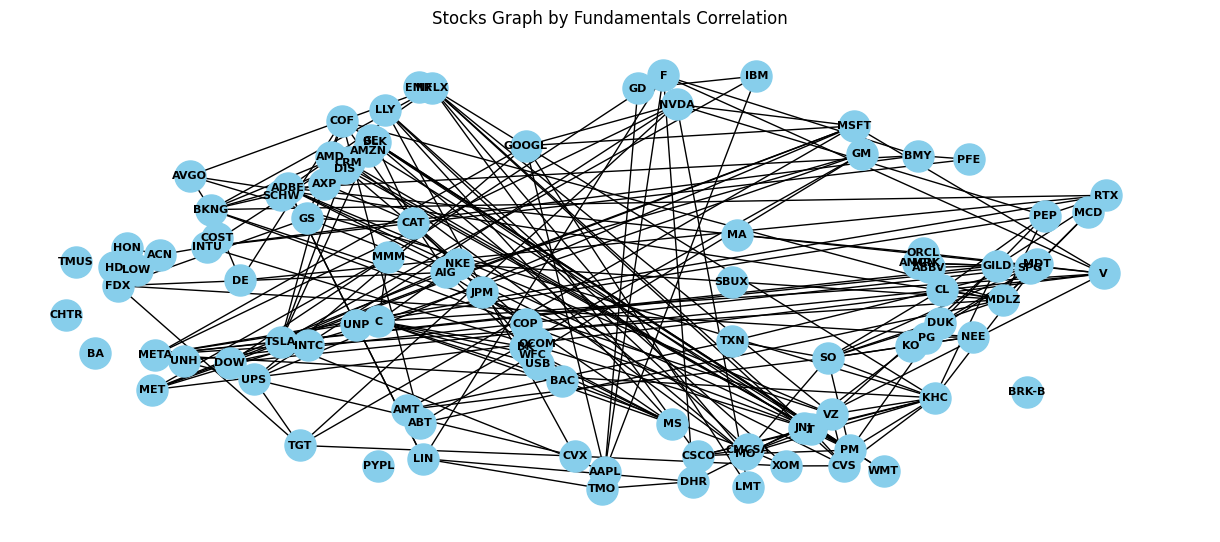

In [18]:
fundamentals_corr_np = fundamentals_corr.to_numpy()
adj_fundamentals_corr = (fundamentals_corr_np * (abs(fundamentals_corr_np) > .7).astype(int))

fundamentals_corr_graph = nx.from_numpy_array(adj_fundamentals_corr)
fundamentals_corr_graph = nx.relabel_nodes(fundamentals_corr_graph, dict(enumerate(fundamentals_corr.index)))

plt.figure(figsize=(12, 5))
nx.draw(fundamentals_corr_graph, with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold', font_color='black', pos=nx.spring_layout(fundamentals_corr_graph))
plt.title('Stocks Graph by Fundamentals Correlation')
plt.show()

## Merging the graphs
To make use of the two graphs to build the final adjacency matrix. A correlation bonus is given to two stocks sharing the same sector.

In [13]:
share_sector = pd.get_dummies(stocks[["Sector"]]).transpose().corr().to_numpy().astype(int) - np.eye(len(stocks), dtype=int)

In [16]:
pd.get_dummies(stocks[["Sector"]]).transpose().corr()

Symbol,2,63,301,333,338,538,568,651,725,776,...,603392,603501,603799,603833,603993,688036,688111,688223,688599,688981
Symbol,,,,,,,,,,,,,,,,,,,,,
2,1.000000,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,...,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408
63,-0.020408,1.000000,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,...,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408
301,-0.020408,-0.020408,1.000000,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,...,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408
333,-0.020408,-0.020408,-0.020408,1.000000,-0.020408,-0.020408,-0.020408,1.000000,-0.020408,-0.020408,...,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408
338,-0.020408,-0.020408,-0.020408,-0.020408,1.000000,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,...,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688036,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,...,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,1.000000,-0.020408,-0.020408,-0.020408,-0.020408
688111,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,...,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,1.000000,-0.020408,-0.020408,-0.020408
688223,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,...,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,1.000000,1.000000,-0.020408


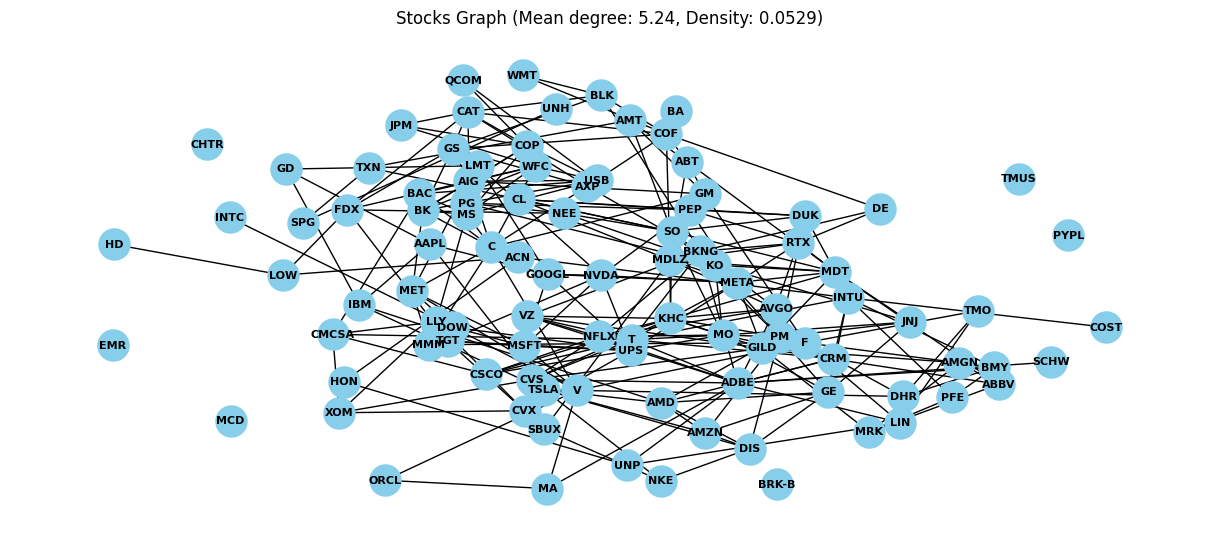

In [19]:
corr_threshold, sector_bonus = .7, .05

share_sector = pd.get_dummies(stocks[["Sector"]]).transpose().corr().to_numpy().astype(int) - np.eye(len(stocks), dtype=int)
# abs because GCNConv only accepts positive weights
adj = abs(fundamentals_corr_np) + share_sector * sector_bonus
adj = adj * (abs(adj) > corr_threshold)  
adj = adj / adj.max()

graph = nx.from_numpy_array(adj)
graph = nx.relabel_nodes(graph, dict(enumerate(stocks.index)))

plt.figure(figsize=(12, 5))
nx.draw(graph, with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold', font_color='black', pos=nx.spring_layout(graph, k=.5))
plt.title(f'Stocks Graph (Mean degree: {np.mean([degree for node, degree in graph.degree]):.2f}, Density: {nx.density(graph):.4f})')
plt.show()

In [20]:
np.save('../data/SP100/raw/adj.npy', adj)